In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, XLMRobertaTokenizer, XLMRobertaModel
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

C:\Users\user\anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# Paths
# base_path = 'D:/Document/BUET/Data Mining/dataset/BHM'
# files_path = os.path.join(base_path, 'Files')
# memes_path = os.path.join(base_path, 'Memes')
# D:\Document\BUET\Data Mining\dataset\Bengali-Aggression-Memes-main\Bengali-Aggression-Memes-main
base_path = 'D:/Document/BUET/Data Mining/dataset/Bengali-Aggression-Memes-main/Bengali-Aggression-Memes-main/Dataset'
files_path = os.path.join(base_path, 'Files')
memes_path = os.path.join(base_path, 'Memes')
# Load datasets
train_data_task3 = pd.read_excel(os.path.join(files_path, 'training_set.xlsx'))
valid_data_task3 = pd.read_excel(os.path.join(files_path, 'validation_set.xlsx'))
test_data_task3 = pd.read_excel(os.path.join(files_path, 'testing_set.xlsx'))
# Reading the CSV files
# train_data_task3 = pd.read_csv(os.path.join(files_path, 'training_set.csv'))
# valid_data_task3 = pd.read_csv(os.path.join(files_path, 'validation_set.csv'))
# test_data_task3 = pd.read_csv(os.path.join(files_path, 'testing_set.csv'))

# train_data_task2 = pd.read_excel(os.path.join(files_path, 'train_task2.xlsx'))
# valid_data_task2 = pd.read_excel(os.path.join(files_path, 'valid_task2.xlsx'))
# test_data_task2 = pd.read_excel(os.path.join(files_path, 'test_task2.xlsx'))

In [5]:
print(train_data_task3.head())


              image_name                                           Captions  \
0            fb 1425.jpg  বিজেপি লিডার: *আমরা ফ্যাসিবাদী না।* বিজেপি সরক...   
1             in 444.jpg  বিজয়া সম্মিলনীর মোড়কে পার্থ-কাণ্ডের 'ড্যামেজ ...   
2   ovodro_img (338).jpg                           হিংস্র বাঘ সেক্সি বাঘিনী   
3            fb 1744.jpg  সরকারি চাকরি করা কাকুর যখন আধাঘন্টা ধরে দার কর...   
4  bangla-troll (21).jpg           হ্যা বাবা মার মার এইভাবে কামড় মারতে হয় !   

                  Label  
0  political aggression  
1  political aggression  
2   gendered aggression  
3   gendered aggression  
4        non-aggressive  


In [6]:
# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [7]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


PyTorch version: 2.5.1+cu121
CUDA version: 12.1
Is CUDA available: True
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [8]:
# Dataset class
class MemeDataset(Dataset):
    def __init__(self, dataframe, image_folder, transforms=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image_name'])
        image = Image.open(image_path).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
        text = row['Captions']
        label = row['Label']
        return image, text, label

In [9]:
# DataLoader function
def create_dataloader(dataframe, image_folder, transforms, batch_size):
    dataset = MemeDataset(dataframe, image_folder, transforms)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 16  # Use a smaller batch size to reduce memory usage
# train_loader_task1 = create_dataloader(train_data_task1, memes_path, image_transforms, batch_size)
# valid_loader_task1 = create_dataloader(valid_data_task1, memes_path, image_transforms, batch_size)
# test_loader_task1 = create_dataloader(test_data_task1, memes_path, image_transforms, batch_size)

train_loader_task3 = create_dataloader(train_data_task3, memes_path, image_transforms, batch_size)
valid_loader_task3 = create_dataloader(valid_data_task3, memes_path, image_transforms, batch_size)
test_loader_task3 = create_dataloader(test_data_task3, memes_path, image_transforms, batch_size)


In [10]:
# Load pre-trained models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
xlmr_model = XLMRobertaModel.from_pretrained("xlm-roberta-base").eval()

In [11]:
# Feature extraction functions
def extract_image_features(images):
    with torch.no_grad():
        return clip_model.get_image_features(images.to(torch.float16 if torch.cuda.is_available() else torch.float32))

def extract_text_features(texts):
    inputs = xlmr_tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = xlmr_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

In [12]:
# Extract and save features
def process_and_save_features(dataloader, split):
    image_features, text_features, labels = [], [], []
    for images, texts, lbls in dataloader:
        img_feats = extract_image_features(images)
        txt_feats = extract_text_features(texts)
        image_features.append(img_feats.cpu().numpy())
        text_features.append(txt_feats.cpu().numpy())
        labels.extend(lbls)
    np.save(f"{split}_image_features.npy", np.vstack(image_features))
    np.save(f"{split}_text_features.npy", np.vstack(text_features))
    np.save(f"{split}_labels.npy", np.array(labels))

# process_and_save_features(train_loader_task1, "train_task1")
# process_and_save_features(valid_loader_task1, "valid_task1")
# process_and_save_features(test_loader_task1, "test_task1")

process_and_save_features(train_loader_task3, "train_task3")
process_and_save_features(valid_loader_task3, "valid_task3")
# process_and_save_features(test_loader_task3, "test_task3")
process_and_save_features(test_loader_task3, "test_task3")


In [15]:
# Load features
# train_image_features_task1 = np.load("train_task1_image_features.npy")
# train_text_features_task1 = np.load("train_task1_text_features.npy")
# train_labels_task1 = np.load("train_task1_labels.npy")

# valid_image_features_task1 = np.load("valid_task1_image_features.npy")
# valid_text_features_task1 = np.load("valid_task1_text_features.npy")
# valid_labels_task1 = np.load("valid_task1_labels.npy")

train_image_features_task3 = np.load("train_task3_image_features.npy")
train_text_features_task3 = np.load("train_task3_text_features.npy")
train_labels_task3 = np.load("train_task3_labels.npy")

valid_image_features_task3 = np.load("valid_task3_image_features.npy")
valid_text_features_task3 = np.load("valid_task3_text_features.npy")
valid_labels_task3 = np.load("valid_task3_labels.npy")

In [16]:
# Concatenate features
def concatenate_features(image_features, text_features):
    return np.hstack((image_features, text_features))

# train_features_task1 = concatenate_features(train_image_features_task1, train_text_features_task1)
# valid_features_task1 = concatenate_features(valid_image_features_task1, valid_text_features_task1)

train_features_task3 = concatenate_features(train_image_features_task3, train_text_features_task3)
valid_features_task3 = concatenate_features(valid_image_features_task3, valid_text_features_task3)

In [17]:
# Encode labels
label_encoder_task3 = LabelEncoder()
train_labels_task3 = label_encoder_task3.fit_transform(train_labels_task3)
valid_labels_task3 = label_encoder_task3.transform(valid_labels_task3)

# label_encoder_task2 = LabelEncoder()
# train_labels_task2 = label_encoder_task2.fit_transform(train_labels_task2)
# valid_labels_task2 = label_encoder_task2.transform(valid_labels_task2)

In [18]:
# Neural Network Model
class MemeClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MemeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [19]:
# Training function with early stopping
def train_model(model, criterion, optimizer, train_features, train_labels, valid_features, valid_labels, epochs=10, patience=6):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(train_features, dtype=torch.float32)
        labels = torch.tensor(train_labels, dtype=torch.long)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_inputs = torch.tensor(valid_features, dtype=torch.float32)
            val_labels = torch.tensor(valid_labels, dtype=torch.long)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_predictions = torch.argmax(val_outputs, dim=1)
            val_accuracy = accuracy_score(valid_labels, val_predictions.numpy())

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val Accuracy: {val_accuracy}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

In [22]:
# Task 3:  Meme Detection (political aggression, religious aggression, gendered aggression, non-aggressive, others)
input_size_task3 = train_features_task3.shape[1]
hidden_size_task3 = 128
num_classes_task3 = len(np.unique(train_labels_task3))
model_task3 = MemeClassifier(input_size_task3, hidden_size_task3, num_classes_task3)
criterion_task3 = nn.CrossEntropyLoss()
optimizer_task3 = optim.Adam(model_task3.parameters(), lr=0.001)

print("Training Task 1 Model")
train_model(model_task3, criterion_task3, optimizer_task3, train_features_task3, train_labels_task3, valid_features_task3, valid_labels_task3, epochs=500)


Training Task 1 Model
Epoch 1/500, Loss: 1.630115270614624, Val Loss: 1.542492389678955, Val Accuracy: 0.2544704264099037
Epoch 2/500, Loss: 1.542754888534546, Val Loss: 1.474016785621643, Val Accuracy: 0.3920220082530949
Epoch 3/500, Loss: 1.4709484577178955, Val Loss: 1.4001457691192627, Val Accuracy: 0.5268225584594223
Epoch 4/500, Loss: 1.3933933973312378, Val Loss: 1.328737735748291, Val Accuracy: 0.579092159559835
Epoch 5/500, Loss: 1.3178439140319824, Val Loss: 1.2617765665054321, Val Accuracy: 0.6189821182943603
Epoch 6/500, Loss: 1.24675452709198, Val Loss: 1.1989706754684448, Val Accuracy: 0.6396148555708391
Epoch 7/500, Loss: 1.1796542406082153, Val Loss: 1.1422321796417236, Val Accuracy: 0.6396148555708391
Epoch 8/500, Loss: 1.1178760528564453, Val Loss: 1.0929186344146729, Val Accuracy: 0.6368638239339752
Epoch 9/500, Loss: 1.0634604692459106, Val Loss: 1.0501571893692017, Val Accuracy: 0.6437414030261348
Epoch 10/500, Loss: 1.015798568725586, Val Loss: 1.0132675170898438,

In [32]:
# Evaluation and Metrics for Task 1
print("\nEvaluation for Task 3")
model_task3.eval()
with torch.no_grad():
    val_inputs_task3 = torch.tensor(valid_features_task3, dtype=torch.float32)
    val_outputs_task3 = model_task3(val_inputs_task3)
    val_predictions_task3 = torch.argmax(val_outputs_task3, dim=1).numpy()

report_task3 = classification_report(valid_labels_task3, val_predictions_task3, target_names=label_encoder_task3.classes_)
print(report_task3)



Evaluation for Task 3
                      precision    recall  f1-score   support

 gendered aggression       0.71      0.75      0.73       144
      non-aggressive       0.60      0.72      0.66       181
              others       0.57      0.48      0.52       141
political aggression       0.89      0.82      0.85       128
religious aggression       0.86      0.78      0.82       133

            accuracy                           0.71       727
           macro avg       0.73      0.71      0.72       727
        weighted avg       0.71      0.71      0.71       727



In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Updated training function to track metrics
def train_model_with_metrics(model, criterion, optimizer, train_features, train_labels, valid_features, valid_labels, epochs=10, patience=6):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(train_features, dtype=torch.float32)
        labels = torch.tensor(train_labels, dtype=torch.long)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        train_predictions = torch.argmax(outputs, dim=1).numpy()
        train_accuracy = accuracy_score(train_labels, train_predictions)

        # Validation
        model.eval()
        with torch.no_grad():
            val_inputs = torch.tensor(valid_features, dtype=torch.float32)
            val_labels = torch.tensor(valid_labels, dtype=torch.long)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_predictions = torch.argmax(val_outputs, dim=1).numpy()
            val_accuracy = accuracy_score(valid_labels, val_predictions)

        # Log metrics
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val Accuracy: {val_accuracy}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and track metrics
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_metrics(
    model_task3, criterion_task3, optimizer_task3,
    train_features_task3, train_labels_task3,
    valid_features_task3, valid_labels_task3,
    epochs=50
)
# report_task2 = classification_report(valid_labels_task2, val_predictions_task2, target_names=label_encoder_task2.classes_)
# print(report_task2)
# Plotting Loss Curves



Epoch 1/50, Loss: 0.5173468589782715, Val Loss: 0.7680887579917908, Val Accuracy: 0.7028885832187071
Epoch 2/50, Loss: 0.5121711492538452, Val Loss: 0.7687554359436035, Val Accuracy: 0.7001375515818432
Epoch 3/50, Loss: 0.5070693492889404, Val Loss: 0.7693943381309509, Val Accuracy: 0.7028885832187071
Epoch 4/50, Loss: 0.5020450949668884, Val Loss: 0.7707127332687378, Val Accuracy: 0.7001375515818432
Epoch 5/50, Loss: 0.4971417188644409, Val Loss: 0.7710840702056885, Val Accuracy: 0.7028885832187071
Epoch 6/50, Loss: 0.4925391376018524, Val Loss: 0.7739935517311096, Val Accuracy: 0.7042640990371389
Epoch 7/50, Loss: 0.48874160647392273, Val Loss: 0.7748067378997803, Val Accuracy: 0.7083906464924347
Early stopping triggered.


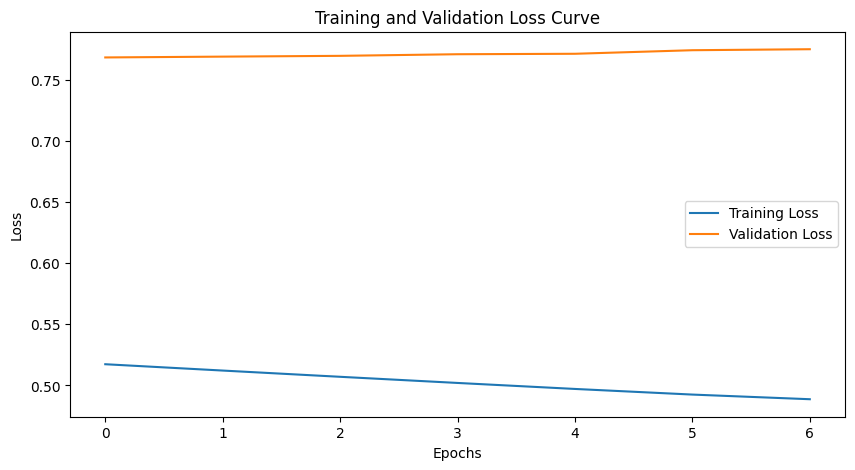

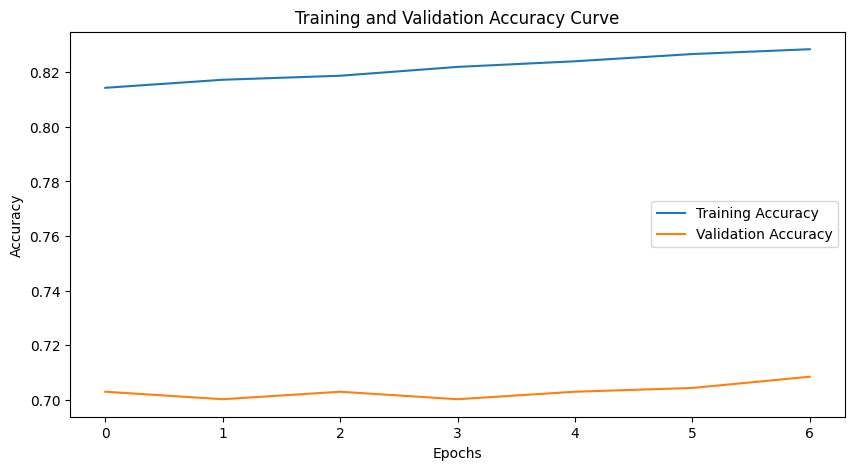

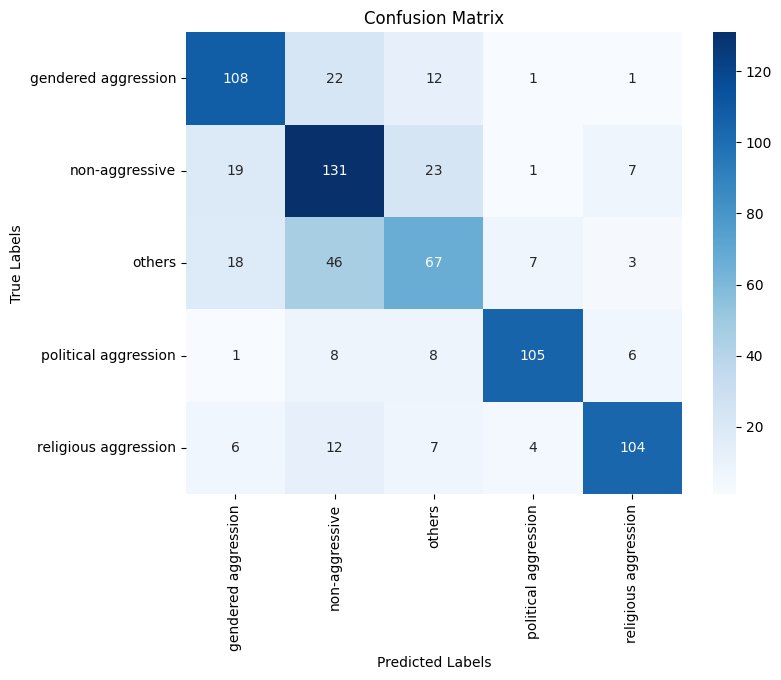

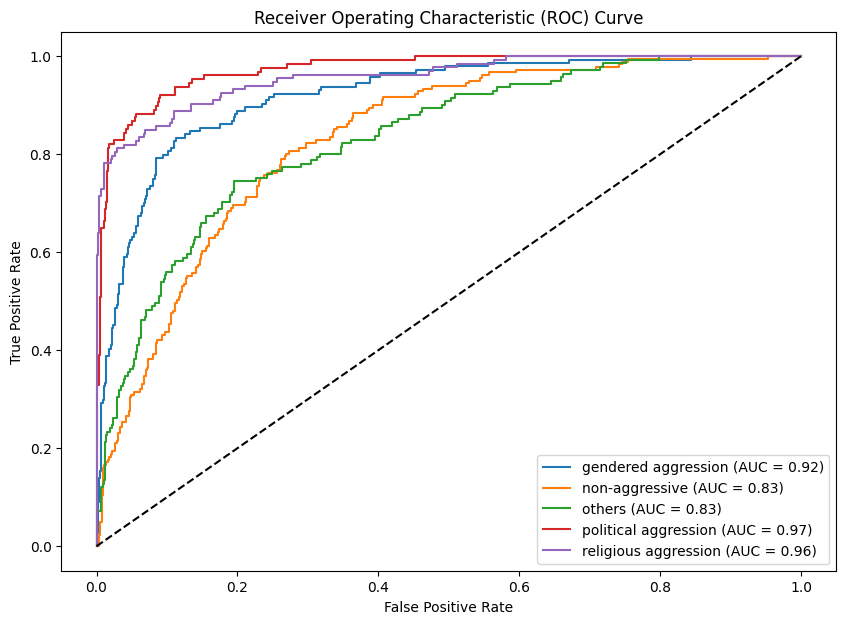

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

# Plotting Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(valid_labels_task3, val_predictions_task3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_task3.classes_, yticklabels=label_encoder_task3.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
plt.figure(figsize=(10, 7))
for i, class_label in enumerate(label_encoder_task3.classes_):
    fpr, tpr, _ = roc_curve(valid_labels_task3 == i, val_outputs_task3[:, i].numpy())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

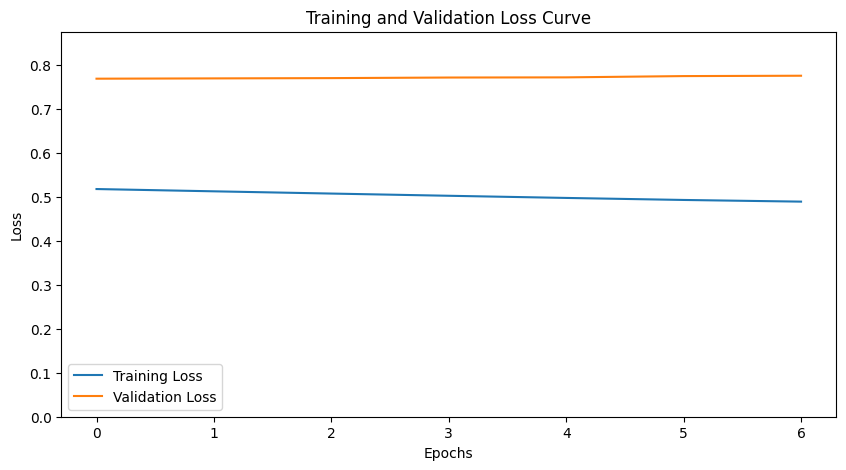

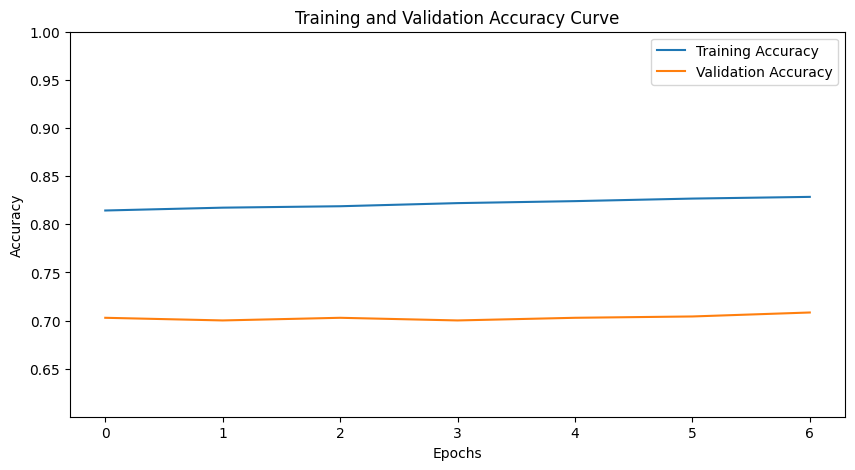

In [36]:
# Plotting Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.ylim(0, max(max(train_losses), max(val_losses)) + 0.1)  # Adjust y-axis range for higher values
plt.legend()
plt.show()

# Plotting Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve')
plt.ylim(min(min(train_accuracies), min(val_accuracies)) - 0.1, 1.0)  # Set accuracy range high
plt.legend()
plt.show()
